In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from shapely.wkt import loads
from shapely.geometry import shape, Point
import urllib.request, json
import requests
import urllib.parse
import os

import warnings
warnings.filterwarnings('ignore')

/Users/lizjohnson/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(
/var/folders/9f/7xdrpjw15kn4wccwzb5xhr0m0000gn/T/ipykernel_31965/1666183220.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to S

In [3]:
camera_locs = pd.read_csv('../Data/aggregated_camera_locs.csv',index_col = 0)
camera_locs['geometry'] = camera_locs['geometry'].apply(loads)
camera_locs = gpd.GeoDataFrame(camera_locs,geometry = 'geometry', crs = '4326')
camera_locs.head()

,Data_Source,Camera_Count,geometry,x,y
0,Amnesty,5,POINT (-73.95673 40.69289),-73.956733,40.692888
1,Amnesty,5,POINT (-73.97285 40.62937),-73.972852,40.629372
2,Amnesty,1,POINT (-73.96565 40.70615),-73.965655,40.706149
3,Amnesty,7,POINT (-73.90359 40.67201),-73.903590,40.672012
4,Amnesty,1,POINT (-73.95976 40.67575),-73.959759,40.675751


In [4]:
building_gdf = gpd.read_file('../Data/bk_building_block_boundary/bk_building_block_boundary.shp')
building_gdf.head()

,index,geometry
0,20.0,"POLYGON ((-73.98473 40.70375, -73.98595 40.703..."
1,30.0,"POLYGON ((-73.98694 40.70317, -73.98717 40.703..."
2,34.0,"POLYGON ((-73.98033 40.70311, -73.98075 40.703..."
3,35.0,"POLYGON ((-73.99323 40.70255, -73.99325 40.702..."
4,42.0,"POLYGON ((-73.98292 40.70237, -73.98433 40.702..."


In [5]:
building_gdf = building_gdf.rename(columns = {'index':'Block'})
building_gdf.columns

Index(['Block', 'geometry'], dtype='object')

In [6]:
bk_bndry = gpd.read_file('../Data/BrooklynBoundary.shp')
bk_bndry.head()

,FID,geometry
0,0,"MULTIPOLYGON (((-74.00198 40.56960, -74.00209 ..."


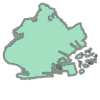

In [7]:
bk_bndry.geometry.values[0]

In [8]:
#convert data to equidistant projection system UTM Zone 18 aka NYC, EPSG:32618

camera_locs = camera_locs.to_crs(32618)
building_gdf = building_gdf.to_crs(32618)
bk_bndry = bk_bndry.to_crs(32618)

In [9]:
camera_locs.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
building_gdf.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
bk_bndry.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
#redefine x and y columns
camera_locs['x'] = camera_locs.geometry.x
camera_locs['y'] = camera_locs.geometry.y
camera_locs.head()

,Data_Source,Camera_Count,geometry,x,y
0,Amnesty,5,POINT (588147.072 4505188.861),588147.071612,4.505189e+06
1,Amnesty,5,POINT (586867.513 4498122.217),586867.512967,4.498122e+06
2,Amnesty,1,POINT (587375.934 4506652.088),587375.933703,4.506652e+06
3,Amnesty,7,POINT (592666.168 4502926.211),592666.167996,4.502926e+06
4,Amnesty,1,POINT (587913.940 4503283.593),587913.939630,4.503284e+06


### Rasterize the building geo dataframe to exclude points from camera data

In [89]:
import rasterio.features

# Define the minimum and maximum bounds of the raster
#change this to the bk boundary shapefile
min_x, min_y, max_x, max_y = bk_bndry.total_bounds

# Create an empty raster with the desired shape and CRS
raster = np.zeros((2500,2500), dtype=np.int16)
transform = rasterio.transform.from_bounds(min_x, min_y, max_x, max_y, 2500, 2500)

# Rasterize the buildings into the raster
buildings_mask = rasterio.features.geometry_mask(building_gdf.geometry, out_shape=raster.shape, transform=transform, invert=True)
raster[buildings_mask] = -9999

# Get the boundary polygon
boundary_polygon = bk_bndry.geometry.values[0]

# Create a mask for the pixels outside the boundary
boundary_mask = rasterio.features.geometry_mask([boundary_polygon], out_shape=raster.shape, transform=transform, invert=False)

# Set the values of the pixels outside the boundary to -9999
raster[boundary_mask] = -9999

# Set the remaining cells to -128
raster[raster == 0] = -128


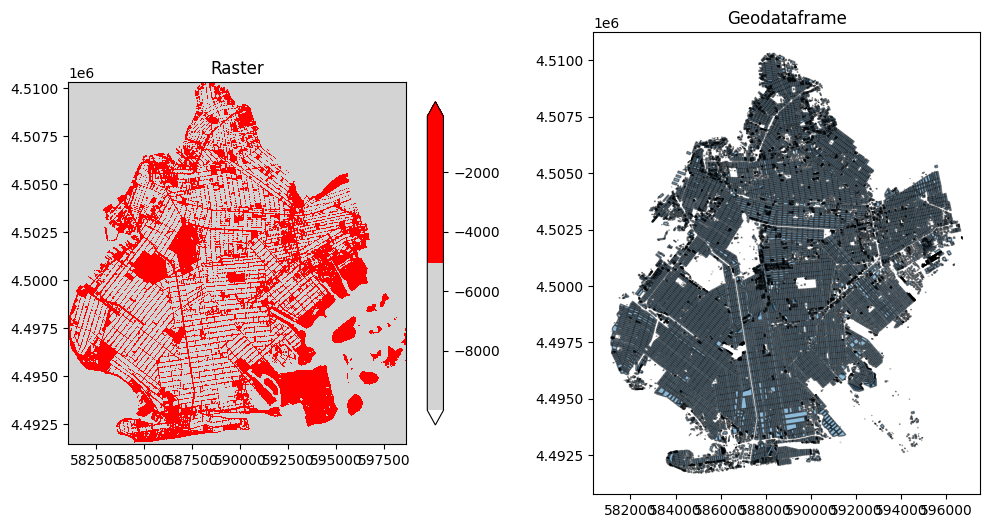

In [90]:
import matplotlib.colors as colors

# Define a color map for the raster
cmap = colors.ListedColormap(['lightgray', 'red'])
cmap.set_under(color='white')

# Plot the raster
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
raster_image = ax1.imshow(raster, cmap=cmap, vmin=-9999, vmax=-128, extent=[min_x, max_x, min_y, max_y])
ax1.set_title('Raster')

# Plot the geodataframe
building_gdf.plot(ax=ax2, alpha=0.5, edgecolor='k')
ax2.set_title('Geodataframe')

# Add a colorbar
fig.colorbar(raster_image, ax=ax1, extend='both', shrink=0.7)

# Show the plot
plt.show()

In [91]:
land_reference = raster
print(land_reference.shape)
#flattens the raster into 1 dimensional array
land_mask = (land_reference > -9999).ravel()
print(land_mask.shape)
x_grid, y_grid = np.meshgrid(np.linspace(min_x, max_x,2500),
                             np.linspace(min_y, max_y, 2500))
grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
print(grid_points.shape)
grid_points = grid_points[land_mask]
print(grid_points.shape)

(2500, 2500)
(6250000,)
(6250000, 2)
(1844524, 2)


In [92]:
# Count occurrences of True and False
true_count = np.count_nonzero(land_mask)
false_count = land_mask.size - true_count

print("True count:", true_count)
print("False count:", false_count)

True count: 1844524
False count: 4405476


In [93]:
#standardize the camera count metric to use as our target variable
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

data = np.asarray(camera_locs['Camera_Count']).reshape(-1, 1)
scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler.fit(data)
y_data = scaler.transform(data)

X_data = np.vstack([camera_locs['x'],camera_locs['y']]).T
# y = np.array(camera_locs["Data_Source"] == "Amnesty", dtype=int)

In [94]:
y_data[:10]

array([[0.25  ],
       [0.25  ],
       [0.    ],
       [0.375 ],
       [0.    ],
       [0.125 ],
       [0.0625],
       [0.    ],
       [0.1875],
       [0.    ]])

In [95]:
X_data[:10]

array([[ 588147.07161245, 4505188.86062826],
       [ 586867.51296664, 4498122.21674541],
       [ 587375.93370312, 4506652.08754618],
       [ 592666.16799647, 4502926.21110367],
       [ 587913.93963028, 4503283.59252384],
       [ 587841.31876905, 4495391.16488008],
       [ 588340.31358102, 4507900.0470682 ],
       [ 589735.68823608, 4492479.78569519],
       [ 591343.2992308 , 4502219.92109406],
       [ 586154.4109412 , 4499844.40780503]])

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.8, random_state=123)

In [97]:
from sklearn.model_selection import GridSearchCV

#try to tune bandwidth parameter
params = {'bandwidth': np.linspace(100, 500, 5)}
#look into the grid object. Does it contain all of the estimators?
#If so, can we use it to plot output of various bandwidths for the gaussian kernel specifically?
grid = GridSearchCV(KernelDensity(metric="euclidean"), params)
grid.fit(X_train,y_train)
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
print("best kernal: {0}".format(grid.best_estimator_.kernel))

best bandwidth: 200.0
best kernal: gaussian


In [98]:
from sklearn.neighbors import KernelDensity

# Define the bandwidth values you want to test
bandwidths = np.linspace(100, 500, 5)

# Create a dictionary of parameters for GridSearchCV
params = {'bandwidth': bandwidths}

# Initialize a list to store the performance metrics for each bandwidth
results = []

# Perform grid search
for bandwidth in bandwidths:
    # Create the KDE model with the specified bandwidth and Gaussian kernel
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')

    # Fit the model
    kde.fit(X_train,y_train)

    # Calculate the performance metrics for the current bandwidth
    # Replace this part with your desired performance metrics calculations
    # Here, I'm just printing the bandwidth and the corresponding log-likelihood score
    score = kde.score(X_test,y_test)
    print("Bandwidth: {0}, Log-Likelihood Score: {1}".format(bandwidth, score))

    # Store the results
    results.append((bandwidth, score))

# Find the best bandwidth and corresponding score
best_bandwidth, best_score = max(results, key=lambda x: x[1])

# Print the best bandwidth and its corresponding score
print("Best Bandwidth: {0}, Best Log-Likelihood Score: {1}".format(best_bandwidth, best_score))

Bandwidth: 100.0, Log-Likelihood Score: -161811.3355877561
Bandwidth: 200.0, Log-Likelihood Score: -159472.49218434203
Bandwidth: 300.0, Log-Likelihood Score: -159780.6708283694
Bandwidth: 400.0, Log-Likelihood Score: -160168.77317259312
Bandwidth: 500.0, Log-Likelihood Score: -160512.37267910936
Best Bandwidth: 200.0, Best Log-Likelihood Score: -159472.49218434203


### Let's fit the KDE with the y variables now and increase our sampling size

In [99]:
kde = KernelDensity(bandwidth = 200, metric="euclidean", kernel='gaussian')
kde.fit(X_data,y_data)

KernelDensity(bandwidth=200)

In [100]:
grid_points.shape

(1844524, 2)

In [104]:
# evaluate only on the land: 0 indicates ocean or building
Z = np.full(land_mask.shape[0], 0.0)
Z[land_mask] = np.exp(kde.score_samples(grid_points))
Z = Z.reshape(x_grid.shape)

In [105]:
print(Z.min(),Z.max())

0.0 6.872534577107005e-08


In [106]:
levels = np.linspace(0, Z.max(), 25)
levels

array([0.00000000e+00, 2.86355607e-09, 5.72711215e-09, 8.59066822e-09,
       1.14542243e-08, 1.43177804e-08, 1.71813364e-08, 2.00448925e-08,
       2.29084486e-08, 2.57720047e-08, 2.86355607e-08, 3.14991168e-08,
       3.43626729e-08, 3.72262290e-08, 4.00897850e-08, 4.29533411e-08,
       4.58168972e-08, 4.86804533e-08, 5.15440093e-08, 5.44075654e-08,
       5.72711215e-08, 6.01346775e-08, 6.29982336e-08, 6.58617897e-08,
       6.87253458e-08])

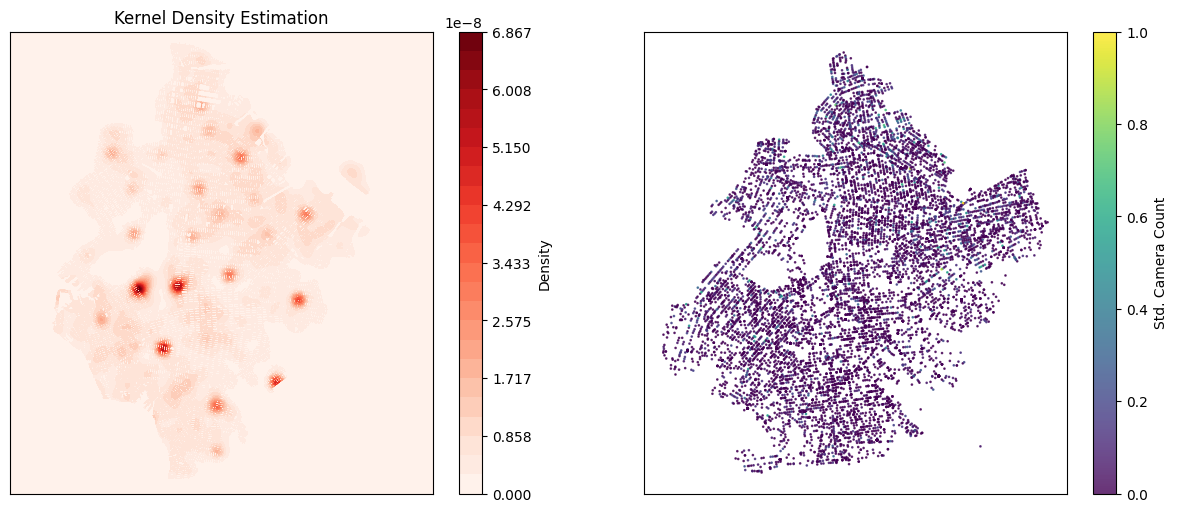

In [85]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
contour = ax[0].contourf(x_grid, y_grid, Z, levels=levels, cmap=plt.cm.Reds)

# Set title
ax[0].set_title('Kernel Density Estimation')

# Plot data as points
scatter = ax[1].scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap='viridis', s = 0.8, alpha = 0.8)

# Add a colorbar for both plots
cbar = plt.colorbar(contour, ax=ax[0])
cbar.set_label('Density')
cbar = plt.colorbar(scatter, ax=ax[1])
cbar.set_label('Std. Camera Count')

# Turn off axes labels
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

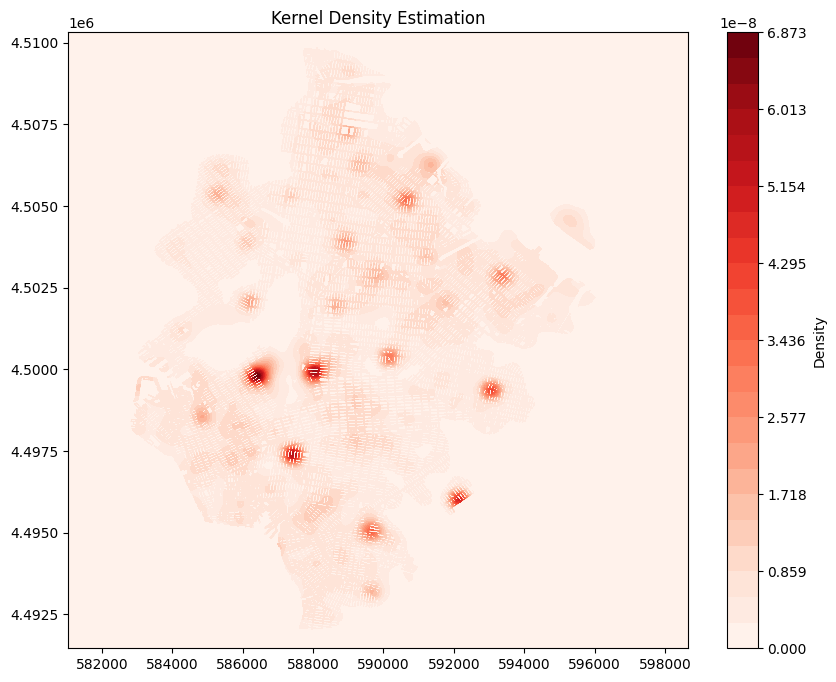

In [111]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(x_grid, y_grid, Z, levels=levels, cmap=plt.cm.Reds)

# Set title
ax.set_title('Kernel Density Estimation')
# Add a colorbar for both plots
cbar = plt.colorbar(contour)
cbar.set_label('Density')
# cbar = plt.colorbar(scatter, ax=ax[1])
# cbar.set_label('Std. Camera Count')

# Turn off axes labels
# ax.set_xticks([])
# ax.set_yticks([])

plt.savefig('../Outputs/KDE_Output_Heatmap.png', bbox_inches = 'tight')
plt.show()

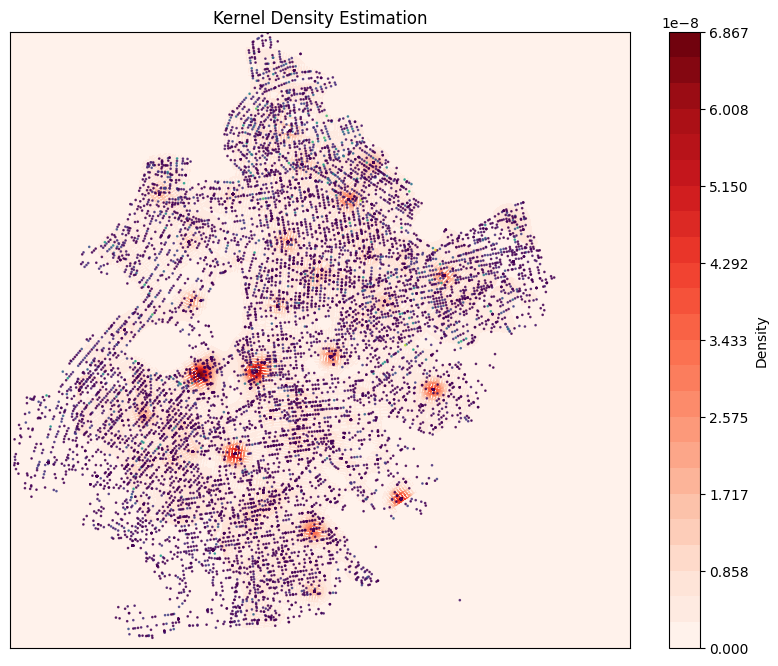

In [87]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(x_grid, y_grid, Z, levels=levels, cmap=plt.cm.Reds)

# Set title
ax.set_title('Kernel Density Estimation')

# Plot data as points
scatter = ax.scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap='viridis', s = 0.8, alpha = 0.8)

# Add a colorbar for both plots
cbar = plt.colorbar(contour)
cbar.set_label('Density')
# cbar = plt.colorbar(scatter, ax=ax[1])
# cbar.set_label('Std. Camera Count')

# Turn off axes labels
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('../Outputs/KDE_Output_Heatmap_camera_locs.png', bbox_inches = 'tight')
plt.show()

In [109]:
import pickle
# Save the array as a pickle file
with open('../Outputs/KDE_output_200m.pickle','wb') as f:
    pickle.dump(Z, f)

In [110]:
Z.shape

(2500, 2500)

## Let's try increasing the bandwidth and plotting the output for comparison

In [107]:
# # Generate grid points for evaluation
# x_grid, y_grid = np.meshgrid(np.linspace(min_x, max_x, 1000),
#                              np.linspace(min_y, max_y, 1000))
# grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# # Define the bandwidth values you want to test
# bandwidths = np.linspace(100, 600, 6)

# # Define the plot
# fig, ax = plt.subplots(2, 3, figsize=(10, 8),layout="constrained")

# # Set the overall figure title
# fig.suptitle('KDE Bandwidth Tuning')

# # Perform grid search
# for i, bandwidth in enumerate(bandwidths):
#     # Create the KDE model with the specified bandwidth and Gaussian kernel
#     kde = KernelDensity(bandwidth=bandwidth, metric="euclidean", kernel='gaussian')
#     kde.fit(X_data, y_data)

#     # Compute log-density values for grid points
#     log_density = kde.score_samples(grid_points)
#     Z = np.exp(log_density).reshape(x_grid.shape)
    
#     # Plotting on the respective subplot
#     subplot_row = i // 3
#     subplot_col = i % 3
#     contour = ax[subplot_row, subplot_col].contourf(x_grid, y_grid, Z, levels=levels, cmap=plt.cm.Reds)

#     # Set the title for the subplot
#     ax[subplot_row, subplot_col].set_title('Bandwidth = {}'.format(bandwidth))

#     # Turn off axes labels
#     ax[subplot_row, subplot_col].set_xticks([])
#     ax[subplot_row, subplot_col].set_yticks([])

# # Add a colorbar for all plots
# cbar = fig.colorbar(contour, ax=ax.ravel().tolist())
# cbar.set_label('Density')
# plt.savefig('../Outputs/KDE_Bandwidth_tuning.png',bbox_inches = 'tight')
# plt.show()

In [108]:
# # Define the plot
# fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True,
#                        gridspec_kw={'wspace': 0.1, 'hspace': 0.2, 'width_ratios': [1, 1, 1]})

# # Set the overall figure title
# fig.suptitle('KDE Bandwidth Tuning')

# # Perform grid search
# for i, bandwidth in enumerate(bandwidths):
#     # Create the KDE model with the specified bandwidth and Gaussian kernel
#     kde = KernelDensity(bandwidth=bandwidth, metric="euclidean", kernel='gaussian')
#     kde.fit(X_data, y_data)

#     # Compute log-density values for grid points
#     log_density = kde.score_samples(grid_points)
#     Z = np.exp(log_density).reshape(x_grid.shape)

#     # Plotting on the respective subplot
#     subplot_row = i // 3
#     subplot_col = i % 3
#     contour = ax[subplot_row, subplot_col].contourf(x_grid, y_grid, Z, levels=levels, cmap=plt.cm.Reds)

#     # Set the title for the subplot
#     ax[subplot_row, subplot_col].set_title('Bandwidth = {}'.format(bandwidth))

#     # Turn off axes labels
#     ax[subplot_row, subplot_col].set_xticks([])
#     ax[subplot_row, subplot_col].set_yticks([])

# # Add a colorbar for all plots
# cbar = fig.colorbar(contour, ax=ax.ravel().tolist(), shrink=0.6)
# cbar.set_label('Density')
# plt.savefig('../Outputs/KDE_Bandwidth_tuning2.png',bbox_inches = 'tight')
# plt.show()